In [1]:
!nvidia-smi

Tue Jun  9 13:51:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Загружаем веса для VGG19.

In [2]:
!wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
vgg_directory = "/content/vgg_conv.pth"

--2020-06-09 13:52:24--  https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
Resolving bethgelab.org (bethgelab.org)... 46.38.232.246
Connecting to bethgelab.org (bethgelab.org)|46.38.232.246|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 160198540 (153M) [text/plain]
Saving to: ‘vgg_conv.pth’

vgg_conv.pth        100%[===================>] 152.78M  9.58MB/s    in 16s     

2020-06-09 13:52:40 (9.33 MB/s) - ‘vgg_conv.pth’ saved [160198540/160198540]



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as tutils
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output
from decimal import Decimal
import matplotlib.pyplot as plt

## NST Model

Оригинальная архитектура сети VGG19 представлена 16 свёрточными слоями в 5 блоках свёртки, после каждого из которых применяется MaxPooling. В то же время Гатис и др. в своей статье отмечают, что использование AvgPooling вместо MaxPooling улучшает градиент и делает результирующие изображения более привлекательными с точки зрения восприятия человеком.

На разных этапах свёртки информация о входном изображении отличается, увеличивается число накопленных признаков благодаря росту количества применённых фильтров. Одновременно с этим уменьшается разрешение самого изображения после очередного применения downsampling-механизма.

Авторы статьи предприняли попытку визуализировать накопленную информацию на разных слоях CNN. Входное изображение было по очереди воссоздано из первого слоя каждого свёрточного блока. В результате удалось выяснить, что реконструированное изображение с первых слоёв первых трёх блоков почти идентично исходному, а далее информация об отдельных пикселях начинает теряться, но при этом сохраняется "высокоуровневая" информация об объектах на изображении, т.е. об их форме, взаимном расположении и т.п.

Кроме того авторы статьи предприняли различные попытки воссоздания стиля изображения. Для сохранения информации о стиле считалась корреляция между всеми выявленными признаками, которые были найдены фильтрами на разных слоях CNN. Далее были использованы 5 различных наборов корреляций, полученных соответственно с первых слоёв следующих свёрточных блоков: 1; 1 и 2; 1-3; 1-4; 1-5. Авторам удалось выяснить, что использование нового дополнительного слоя для реконструкции стиля постепенно увеличивает масштаб отрисовки отдельного признака, при этом информация о взаимном расположении данных признаков постепенно утрачивается.

Таким образом самым рациональным подходом для Style Transfer алгоритма будет использование карты признаков одного из "верхних" слоёв CNN для переноса контента на результирующее изображение, и использование нескольких "глубоких" слоёв CNN для переноса стиля. Авторами статьи были использованы первые слои всех пяти блоков для сохранения стиля и один слой четвёртого блока для переноса контента.

Для повторения некоторых экспериментов, описанных и проведённых Гатисом и др., определим параметризованный конструктор, для возможности создания сетей с различным pooling-типом и параметризованную функцию forward(), чтобы иметь возможность определять выходы каких слоёв мы будем использовать при переносе стиля.

In [0]:
class VGG_nst(nn.Module):
    def __init__(self, pooling=None):
        super(VGG_nst,self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        

        if pooling is 'avg':
            self.pool_1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_5 = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_5 = nn.MaxPool2d(kernel_size=2, stride=2)

        
    def forward(self, x, out_layers):
        out = {}
        out['conv1_1'] = F.relu(self.conv1_1(x))
        out['conv1_2'] = F.relu(self.conv1_2(out['conv1_1']))
        out['pool_1'] = self.pool_1(out['conv1_2'])
        
        out['conv2_1'] = F.relu(self.conv2_1(out['pool_1']))
        out['conv2_2'] = F.relu(self.conv2_2(out['conv2_1']))
        out['pool_2'] = self.pool_2(out['conv2_2'])
        
        out['conv3_1'] = F.relu(self.conv3_1(out['pool_2']))
        out['conv3_2'] = F.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = F.relu(self.conv3_3(out['conv3_2']))
        out['conv3_4'] = F.relu(self.conv3_4(out['conv3_3']))
        out['pool_3'] = self.pool_3(out['conv3_4'])
        
        out['conv4_1'] = F.relu(self.conv4_1(out['pool_3']))
        out['conv4_2'] = F.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = F.relu(self.conv4_3(out['conv4_2']))
        out['conv4_4'] = F.relu(self.conv4_4(out['conv4_3']))
        out['pool_4'] = self.pool_4(out['conv4_4'])
        
        out['conv5_1'] = F.relu(self.conv5_1(out['pool_4']))
        out['conv5_2'] = F.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = F.relu(self.conv5_3(out['conv5_2']))
        out['conv5_4'] = F.relu(self.conv5_4(out['conv5_3']))
        out['pool_5'] = self.pool_5(out['conv5_4'])

        return [out[layer] for layer in out_layers]

In [0]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h*w) #BxCx(HxW)
        # torch.bmm
        # f: [BxCx(HxW)] @ [Bx(HxW)xC] -> [BxCxC]
        G = torch.bmm(f, f.transpose(1, 2))
        return G.div_(h*w)

class StyleLoss(nn.Module):
    def forward(self, input, target):
        GramInput = GramMatrix()(input)
        return nn.MSELoss()(GramInput, target)

## Utils

In [0]:
def preprocess(img, size):
    img = transforms.Resize(size)(img)
    img = transforms.ToTensor()(img)
    img = transforms.Lambda(lambda x:x[torch.LongTensor([2, 1, 0])])(img) #RGB to BGR
    img = transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1])(img) #imagenet mean
    img = transforms.Lambda(lambda x: x.mul_(255))(img)
    return img


def postprocess(img):
    img = transforms.Lambda(lambda x: x.mul_(1./255))(img)
    img = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1])(img)
    img = transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])])(img) #turn to RGB
    img = img.clamp_(0,1)
    return img


def load_img(path, img_size):
    img = Image.open(path)
    img = preprocess(img, img_size)
    img = img.unsqueeze(0)
    return img.to(device)


def load_raw_img(path):
    image = Image.open(path)
    image_tensor = transforms.ToTensor()(image)
    return image_tensor.unsqueeze(0)


def get_preview(tensor):
    image_tensor = tensor.cpu().clone()
    image = transforms.ToPILImage()(image_tensor.squeeze(0))
    image = transforms.Resize(imsize)(image)
    image = transforms.CenterCrop(imsize)(image)
    return image


def show_intermediate_results(content, styles, output):
    column = 4 if len(styles) == 2 else 3
    scale = 6

    clear_output(wait=True)
    
    fig = plt.figure(figsize=(column*scale, scale))
    
    ax1 = plt.subplot(1, column, 1)
    ax1.imshow(get_preview(content))
    ax1.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1.set_title("Content Image")

    ax2 = plt.subplot(1, column, column)
    ax2.imshow(get_preview(output))
    ax2.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2.set_title("Output Image")

    if len(styles) <= 2:
        ax3 = plt.subplot(1, column, 2)
        ax3.imshow(get_preview(styles[0]))
        ax3.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax3.set_title("Style Image")

    if len(styles) == 2:
        ax4 = plt.subplot(1, column, 3)
        ax4.imshow(get_preview(styles[1]))
        ax4.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax4.set_title("Second Style Image")

    if len(styles) >= 3:
        ax5 = plt.subplot(2, 6, 3)
        ax5.imshow(get_preview(styles[0]))
        ax5.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax5.set_title("Style 1")
        
        ax6 = plt.subplot(2, 6, 4)
        ax6.imshow(get_preview(styles[1]))
        ax6.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax6.set_title("Style 2")

        ax7 = plt.subplot(2, 6, 9)
        ax7.imshow(get_preview(styles[2]))
        ax7.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax7.set_title("Style 3")

    if len(styles) > 3:
        ax8 = plt.subplot(2, 6, 10)
        ax8.imshow(get_preview(styles[3]))
        ax8.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax8.set_title("Style 4")

    plt.show()
    return


def show_styles_and_weights(styles):
    columns = len(styles)
    scale = 4
    fig = plt.figure(figsize=(columns*scale, scale))
    fig.suptitle('These styles would be added to output picture:', fontsize=16)
    i = 0
    for path, weight in styles.items():
        ax = plt.subplot(1, columns, i+1)
        ax.imshow(get_preview(load_raw_img(path)))
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax.set_title("{:.2f}% of total style".format(weight*100))
        i += 1
    return


def draw_nst_examples(picture_set, ratio_set, layers_set, scale=4):
    nrows = len(layers_set)
    ncols = len(ratio_set)
    i = 0
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale), sharey=True, sharex=True)
    for row in range(nrows):
        for col in range(ncols):
            ax[row, col].imshow(get_preview(picture_set[i]))
            ax[row, col].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
            ax[row, col].set_title("α/β ratio:" + f"{Decimal(ratio_set[col]):.0e}")
            ax[row, col].set_ylabel(str(layers_set[row][-1]))
            i += 1
    return

## Train

In [0]:
def run_style_transfer(model, optim_img, optimizer, iter_num, loss_layers, targets, loss_funcs, weights, verbose=True):
    if verbose:
        style_prev = [load_raw_img(path) for path in style_paths]
        content_prev = load_raw_img(content_path)
    #history = []
    for iteration in tqdm(range(iter_num)):
        def closure():
            optimizer.zero_grad()
            out = model(optim_img, loss_layers)
            totalLossList = []
            for i in range(len(out)):
                criterion = loss_funcs[i]
                output = out[i]
                target = targets[i]
                weight = weights[i]
                loss = criterion(output, target) * weight
                totalLossList.append(loss)
                #history.append(loss.item())
            total_loss = sum(totalLossList)
            total_loss.backward()
            #history.append(total_loss.item())
            return total_loss
        optimizer.step(closure)

        if iteration % 5 == 0 and verbose:
            int_result = postprocess(optim_img.data[0].cpu().squeeze())
            show_intermediate_results(content_prev, style_prev, int_result)
    out_img = optim_img.data[0].cpu().squeeze()
    res_img = postprocess(out_img)
    return #history

In [0]:
def normalize_weights(styles_dict):
    total = sum(styles_dict.values())
    for k, v in style_paths.items():
        style_paths[k] = float(v)/total


def get_model(path_to_pretrained, pooling='avg'):
    if pooling != 'avg' and pooling != 'max':
        raise BaseException("Неправильно указан pooling-тип. " +
                            "Допустимые значения: avg, max.")
    model = VGG_nst(pooling)
    model.load_state_dict(torch.load(path_to_pretrained))
    for param in model.parameters():
        param.requires_grad = False
    return model.to(device)


def get_loss_funcs(style_layers, content_layers):
    style_losses = [StyleLoss()] * len(style_layers)
    content_losses = [nn.MSELoss()] * len(content_layers)
    funcs = style_losses + content_losses
    funcs = [f.to(device) for f in funcs]
    return funcs


def get_targets(model, style_layers, content_layers, style_images, content_image):
    style_targets = []
    for img, weight in style_images:
        style_targets.append([GramMatrix()(t).detach() * weight for t in model(img, style_layers)])
    style_targets = [sum(t) for t in zip(*style_targets)]
    content_targets = [t.detach() for t in model(content_image, content_layers)]
    targets = style_targets + content_targets
    return targets

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']



content_path = "/content/balley.png"
style_paths = {
               '/content/00 (1).jpg': 10,
               '/content/s1200.jpg': 0,
               '/content/vangogh_starry_night.jpg': 99,
               '/content/00 (4).jpg': 15,
               }

normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [ ]:
imsize = 512

style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [0]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e3  # 1000
content_weight = 1   # 5
weights = [style_weight] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

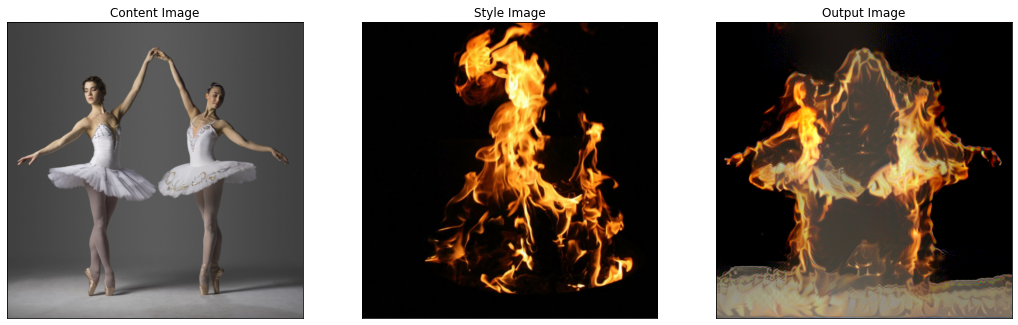

100%|██████████| 80/80 [03:48<00:00,  2.86s/it]


In [12]:
run_style_transfer(model = nst_model,
                   optim_img = optimImg,
                   optimizer = optimizer,
                   iter_num = 5,
                   loss_layers = loss_layers,
                   targets = targets,
                   loss_funcs = loss_funcs,
                   weights = weights,
                   verbose = True)

## Comparison of different subsets of style layers

The loss function we minimise is

$L_{total}(\vec{p},\vec{a},\vec{x})$ = $\alpha$ $L_{content}(\vec{p},\vec{x})$ + $\beta$ $L_{style}(\vec{a},\vec{x})$

where $\vec{a}$ is style image, $\vec{p}$ is content image, $\vec{x}$ is generated (output) image and
$\alpha$ and $\beta$ are the weighting factors for content and style.

In [ ]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

alpha_beta_ratios = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [ ]:
style_layers_subsets = [[s for s in style_layers[:i+1]] for i in range(5)]
style_layers_subsets

In [ ]:
style_content_weights_sets = [(1/ratio, 1) for ratio in alpha_beta_ratios]
style_content_weights_sets

In [ ]:
pics = []

for layers_set in style_layers_subsets:
    for weights_set in style_content_weights_sets:
        style_layers = layers_set
        content_layers = ['conv4_2']

        content_path = '/content/Tuebingen_Neckarfront.jpg'
        style_paths = { '/content/vangogh_starry_night.jpg': 1 }
        normalize_weights(style_paths)

        imsize = 512
        style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
        content_image = load_img(content_path, imsize)

        nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
        targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
        loss_funcs = get_loss_funcs(style_layers, content_layers)
        loss_layers = style_layers + content_layers

        style_weight, content_weight = weights_set
        factor = 1. / len(style_layers)
        weights = [style_weight*factor] * len(style_layers) + [content_weight] * len(content_layers)

        optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
        optimizer = optim.LBFGS([optimImg])

        img, h = run_style_transfer(model = nst_model,
                   optim_img = optimImg,
                   optimizer = optimizer,
                   iter_num = 100,
                   loss_layers = loss_layers,
                   targets = targets,
                   loss_funcs = loss_funcs,
                   weights = weights,
                   verbose = False)
        
        pics.append(img)

In [ ]:
draw_nst_examples(picture_set = pics,
                  ratio_set = alpha_beta_ratios,
                  layers_set = style_layers_subsets)